In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn


### MERGING TWO DATASETS

In [3]:
fear_df = pd.read_csv('/content/fear_greed_index.csv')
hist_df = pd.read_csv('/content/historical_data.csv')

In [4]:
fear_df['date'] = pd.to_datetime(fear_df['date'])
hist_df['trade_time_utc'] = pd.to_datetime(hist_df['Timestamp'], unit='ms', utc=True)

hist_df['trade_date'] = hist_df['trade_time_utc'].dt.date
fear_df['date_only'] = fear_df['date'].dt.date

In [5]:
merged_df = pd.merge(
    hist_df,
    fear_df[['date_only', 'value', 'classification']],
    left_on='trade_date',
    right_on='date_only',
    how='left'
)

###DATA PREPROCESSING

In [6]:
merged_df.drop(columns=['date_only'], inplace=True)
merged_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_time_utc,trade_date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27,74.0,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27,74.0,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27,74.0,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27,74.0,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-10-27 03:33:20+00:00,2024-10-27,74.0,Greed


In [7]:
print(merged_df.isnull().sum())

Account                 0
Coin                    0
Execution Price         0
Size Tokens             0
Size USD                0
Side                    0
Timestamp IST           0
Start Position          0
Direction               0
Closed PnL              0
Transaction Hash        0
Order ID                0
Crossed                 0
Fee                     0
Trade ID                0
Timestamp               0
trade_time_utc          0
trade_date              0
value               26961
classification      26961
dtype: int64


In [8]:
merged_df.shape

(211224, 20)

In [9]:
merged_df = merged_df.dropna(subset=['value', 'classification'], how='all')

In [10]:
print(merged_df.isnull().sum())
print(merged_df.shape)

Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
trade_time_utc      0
trade_date          0
value               0
classification      0
dtype: int64
(184263, 20)


In [11]:
print(f"\nSentiment balance:")
sentiment_counts = merged_df['classification'].value_counts()
print(sentiment_counts)


Sentiment balance:
classification
Fear             133871
Greed             36289
Neutral            7141
Extreme Greed      6962
Name: count, dtype: int64


###Data Analysis

###BASIC COMPARISION

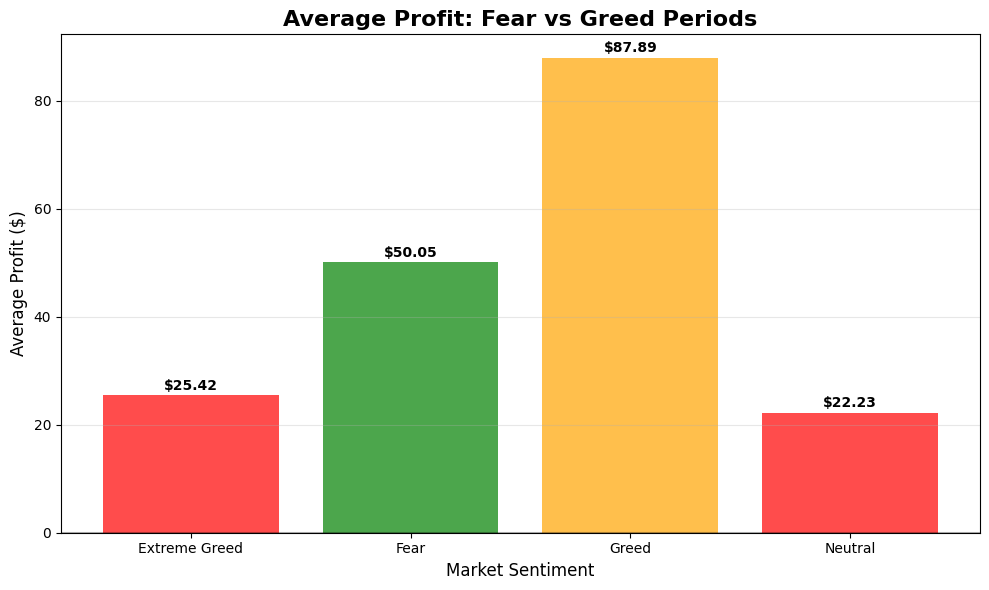

In [12]:
import os

def visualize_fear_vs_greed(df):

    avg_profits = df.groupby('classification')['Closed PnL'].mean()

    plt.figure(figsize=(10, 6))
    bars = plt.bar(avg_profits.index, avg_profits.values,
                   color=['red', 'green', 'orange'], alpha=0.7)

    for bar, value in zip(bars, avg_profits.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'${value:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.title('Average Profit: Fear vs Greed Periods', fontsize=16, fontweight='bold')
    plt.ylabel('Average Profit ($)', fontsize=12)
    plt.xlabel('Market Sentiment', fontsize=12)
    plt.grid(axis='y', alpha=0.3)


    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)


    os.makedirs('outputs', exist_ok=True)
    plt.savefig("outputs/avg_pnl_by_sentiment.png", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()


visualize_fear_vs_greed(merged_df)

In [13]:
def compare_fear_vs_greed(df):
    """Compare trading performance during Fear vs Greed periods"""

    fear_trades = df[df['classification'] == 'Fear']['Closed PnL']
    greed_trades = df[df['classification'] == 'Greed']['Closed PnL']
    extreme_trades = df[df['classification'] == 'Extreme Greed']['Closed PnL']
    neutral_trades = df[df['classification'] == 'Neutral']['Closed PnL']

    print("=== FEAR vs GREED COMPARISON ===")
    print(f"Fear period trades: {len(fear_trades)}")
    print(f"Greed period trades: {len(greed_trades)}")
    print(f"Extreme Greed period trades: {len(extreme_trades)}")
    print(f"Neutral period trades: {len(neutral_trades)}")

    fear_avg = fear_trades.mean()
    greed_avg = greed_trades.mean()
    extreme_avg = extreme_trades.mean()
    neutral_avg = neutral_trades.mean()

    print(f"\nAVERAGE PROFITS:")
    print(f"Fear days: ${fear_avg:.2f}")
    print(f"Greed days: ${greed_avg:.2f}")
    print(f"Extreme Greed days: ${extreme_avg:.2f}")
    print(f"Neutral days: ${neutral_avg:.2f}")

    print(f"\nWIN RATES:")
    fear_win_rate = (fear_trades > 0).mean()
    greed_win_rate = (greed_trades > 0).mean()
    extreme_win_rate = (extreme_trades > 0).mean()
    neutral_win_rate = (neutral_trades > 0).mean()
    print(f"Fear days: {fear_win_rate:.1%}")
    print(f"Greed days: {greed_win_rate:.1%}")
    print(f"Extreme Greed days: {extreme_win_rate:.1%}")
    print(f"Neutral days: {neutral_win_rate:.1%}")

    print(f"\nTOTAL PROFITS:")
    print(f"Fear days total: ${fear_trades.sum():,.2f}")
    print(f"Greed days total: ${greed_trades.sum():,.2f}")
    print(f"Extreme Greed days total: ${extreme_trades.sum():,.2f}")
    print(f"Neutral days total: ${neutral_trades.sum():,.2f}")

    # The main conclusion
    print(f"\nCONCLUSION:")
    if fear_avg > greed_avg:
        print("Traders perform BETTER during Fear periods!")
        print(f"Fear is ${fear_avg - greed_avg:.2f} more profitable per trade\n")
    else:
        print("Traders perform BETTER during Greed periods!")
        print(f"Greed is ${greed_avg - fear_avg:.2f} more profitable per trade\n")

    for mood in ['Fear', 'Greed']:
      count = (df['classification'] == mood).sum()
      print(f"{mood}: {count} trades")



    return fear_avg, greed_avg

X, Y = compare_fear_vs_greed(merged_df)


=== FEAR vs GREED COMPARISON ===
Fear period trades: 133871
Greed period trades: 36289
Extreme Greed period trades: 6962
Neutral period trades: 7141

AVERAGE PROFITS:
Fear days: $50.05
Greed days: $87.89
Extreme Greed days: $25.42
Neutral days: $22.23

WIN RATES:
Fear days: 41.5%
Greed days: 44.6%
Extreme Greed days: 49.0%
Neutral days: 31.7%

TOTAL PROFITS:
Fear days total: $6,699,925.19
Greed days total: $3,189,616.54
Extreme Greed days total: $176,965.49
Neutral days total: $158,742.38

CONCLUSION:
Traders perform BETTER during Greed periods!
Greed is $37.85 more profitable per trade

Fear: 133871 trades
Greed: 36289 trades


As we can see from the graph visuals the traders are in profit during the greed peroid by this we can say that market is profitable during the greed peroid

## Number of trades

In [14]:
trade_counts = merged_df.groupby('classification').size().reset_index(name='Number of Trades')

print(trade_counts)

  classification  Number of Trades
0  Extreme Greed              6962
1           Fear            133871
2          Greed             36289
3        Neutral              7141


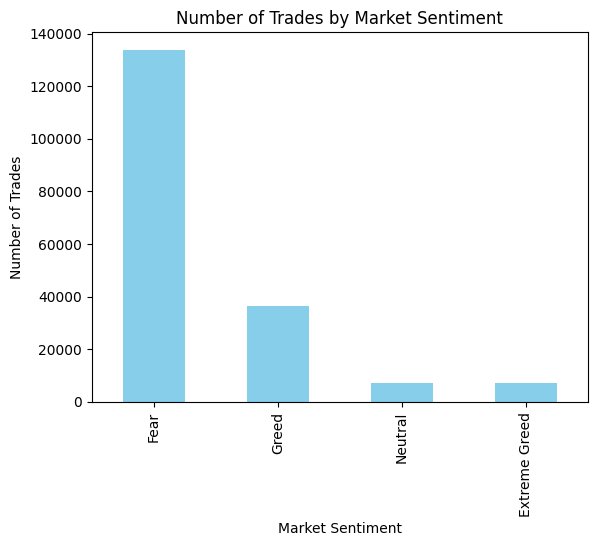

In [15]:
import matplotlib.pyplot as plt

merged_df['classification'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Number of Trades by Market Sentiment')
plt.ylabel('Number of Trades')
plt.xlabel('Market Sentiment')
plt.show()


  classification  Side  Number of Trades
0  Extreme Greed   BUY              3371
1  Extreme Greed  SELL              3591
2           Fear   BUY             66081
3           Fear  SELL             67790
4          Greed   BUY             15421
5          Greed  SELL             20868
6        Neutral   BUY              3505
7        Neutral  SELL              3636


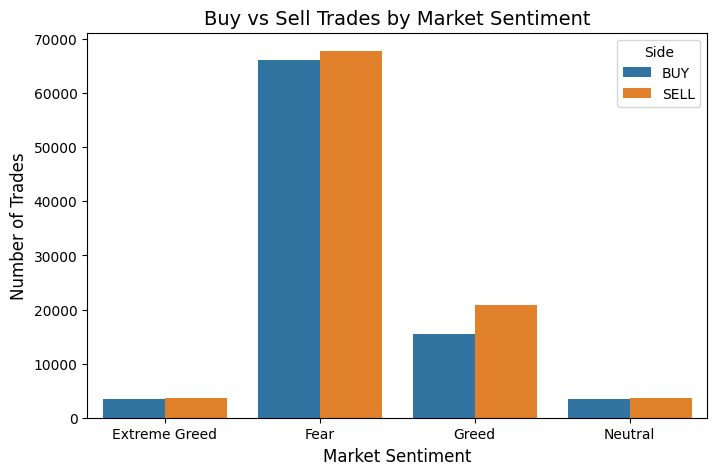

In [16]:
trade_counts_by_sentiment_side = (
    merged_df.groupby(['classification', 'Side'])
      .size()
      .reset_index(name='Number of Trades')
)

print(trade_counts_by_sentiment_side)

plt.figure(figsize=(8,5))
sns.barplot(data=trade_counts_by_sentiment_side, x='classification', y='Number of Trades', hue='Side')

plt.title('Buy vs Sell Trades by Market Sentiment', fontsize=14)
plt.xlabel('Market Sentiment', fontsize=12)
plt.ylabel('Number of Trades', fontsize=12)
plt.legend(title='Side')
plt.show()

1.   From the graph visual it is clear that the market is heavliy       active during the fear period. As we can see there nearly equal number of trades that have been done in fear period
2.   In greed period we can see that there is a slight high in selling because of good price of trade and the interpretation that can be taken from the graph is in greed period they sell rather than buying the trades because of good prices
3.   In neutral also there only little difference in between the sell and buy people tend to sell
4.    In extreme greed people buy rather then selling because they get relativily higher profit

## Before and After of start position

In [17]:
merged_df['End Position'] = merged_df['Start Position'] + (
    merged_df['Size Tokens'] * merged_df['Side'].map({'BUY': 1, 'SELL': -1})
)


In [18]:
for classi in merged_df['classification'].unique():
    trades = merged_df[merged_df['classification'] == classi]

    avg_start = trades['Start Position'].mean()
    avg_end = trades['End Position'].mean()

    print(f"Average Start Position during {classi}: {avg_start:.2f}")
    print(f"Average End Position during {classi}: {avg_end:.2f}")

    if avg_end > avg_start:
        print(f"On average, traders INCREASE their positions during {classi} periods.\n")
    else:
        print(f"On average, traders DECREASE their positions during {classi} periods.\n")


Average Start Position during Greed: 19741.01
Average End Position during Greed: 19606.60
On average, traders DECREASE their positions during Greed periods.

Average Start Position during Fear: 13170.98
Average End Position during Fear: 13141.83
On average, traders DECREASE their positions during Fear periods.

Average Start Position during Extreme Greed: 70307.28
Average End Position during Extreme Greed: 70292.31
On average, traders DECREASE their positions during Extreme Greed periods.

Average Start Position during Neutral: 5895.82
Average End Position during Neutral: 6670.37
On average, traders INCREASE their positions during Neutral periods.



Greed: Traders start with an average position of about 19,741 and end slightly lower at 19,606. This small reduction suggests they’re scaling back a bit, possibly to secure profits or manage risk during a bullish phase.

Fear: Positions also dip slightly in Fear periods, from 13,170 to 13,141. This could mean traders are quick to take profits or are being extra cautious in uncertain, volatile conditions.

Extreme Greed: Even with sentiment at its most bullish, traders reduce positions slightly, from 70,307 to 70,292. This cautious trimming may reflect concerns about a possible reversal, which ties in with earlier findings of lower profits during these periods.

Neutral: In Neutral sentiment, traders go the other way — increasing their positions from 5,895 to 6,670. This may signal more confidence in steady market conditions or a willingness to build positions when sentiment isn’t leaning too far in either direction

## Trade size

----Average Trade Size by Sentiment---
       Sentiment  Avg Size (Tokens)  Avg Size (USD)
0  Extreme Greed       48736.443323     5660.265764
1           Fear        3071.523165     5259.977837
2          Greed        2232.117751     3182.883845
3        Neutral        1967.302964     3058.848110


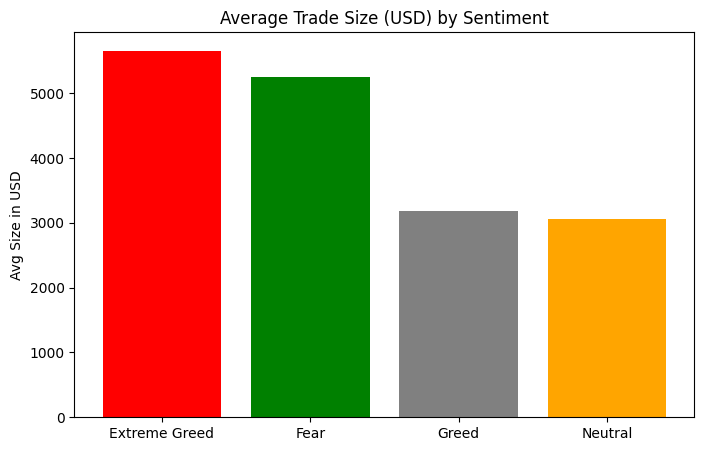

In [19]:

trade_size_stats = merged_df.groupby('classification').agg({
    'Size Tokens': 'mean',
    'Size USD': 'mean'
}).reset_index()

trade_size_stats.columns = ['Sentiment', 'Avg Size (Tokens)', 'Avg Size (USD)']

print("----Average Trade Size by Sentiment---")
print(trade_size_stats)

# Optional: sort so Greed/Fear is easy to compare
trade_size_stats = trade_size_stats.sort_values(by='Avg Size (USD)', ascending=False)

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(trade_size_stats['Sentiment'], trade_size_stats['Avg Size (USD)'], color=['red','green','gray','orange'])
plt.title("Average Trade Size (USD) by Sentiment")
plt.ylabel("Avg Size in USD")
plt.show()


Trade size simply means how big the trade is

*   Big trade size = more money at risk
*   Smaller trade = less money at risk

---

1.   Extreme Greed has largest trade size which means they commit the most capital when the market sentiment is in extreme greed
2.   Fear has the second highest or largest trade size which means the traders are seeing fear periods as oppurtunity
3.   Greed trade size has significantly dropped the reason might be the traders may might for extreme greed sentiment in the market
4.   Neutral the trade size is least which means where is no increase or decrease in the market



## Which yeilds more profit

In [20]:
#
profit_by_side_sentiment = (
    merged_df.groupby(['classification', 'Side'])['Closed PnL']
    .agg(['count', 'mean', 'sum'])
    .reset_index()
)

profit_by_side_sentiment = profit_by_side_sentiment.rename(
    columns={
        'classification': 'Sentiment',
        'Side': 'Trade Side',
        'count': 'Number of Trades',
        'mean': 'Avg Profit',
        'sum': 'Total Profit'
    }
)

print("=== Profitability by Sentiment and Trade Side ===")
print(profit_by_side_sentiment)

# Optional: Sort by sentiment for easier reading
sentiment_order = ['Extreme Greed', 'Greed', 'Neutral', 'Fear']
profit_by_side_sentiment['Sentiment'] = pd.Categorical(
    profit_by_side_sentiment['Sentiment'],
    categories=sentiment_order,
    ordered=True
)
profit_by_side_sentiment = profit_by_side_sentiment.sort_values(['Sentiment', 'Trade Side'])


=== Profitability by Sentiment and Trade Side ===
       Sentiment Trade Side  Number of Trades  Avg Profit  Total Profit
0  Extreme Greed        BUY              3371   25.578564  8.622534e+04
1  Extreme Greed       SELL              3591   25.268770  9.074015e+04
2           Fear        BUY             66081   58.074630  3.837630e+06
3           Fear       SELL             67790   42.222976  2.862296e+06
4          Greed        BUY             15421   12.489506  1.926007e+05
5          Greed       SELL             20868  143.617782  2.997016e+06
6        Neutral        BUY              3505   15.646108  5.483961e+04
7        Neutral       SELL              3636   28.576120  1.039028e+05


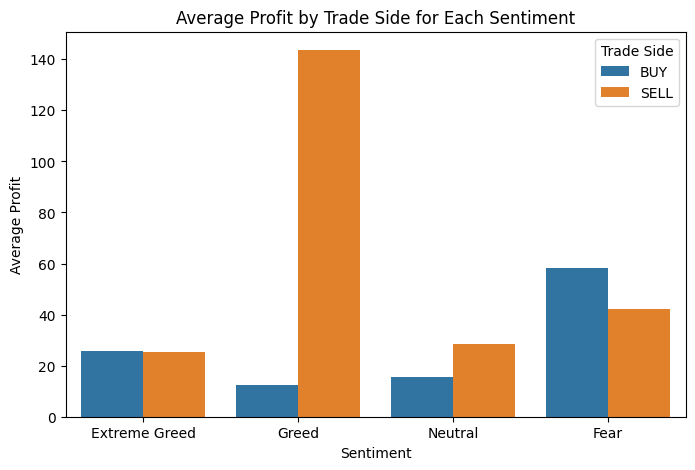

In [21]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=profit_by_side_sentiment,
    x='Sentiment',
    y='Avg Profit',
    hue='Trade Side'
)
os.makedirs('outputs', exist_ok=True)
plt.savefig("outputs/avg_profit_by_trade.png", dpi=300, bbox_inches='tight')
plt.title("Average Profit by Trade Side for Each Sentiment")
plt.ylabel("Average Profit")
plt.show()




1.   Greed - From above data we can say that if we sell the bitcoins in greed we are in more benefits which makes sense as people will be buying more and more
2.   Fear - Buying is performing well in fear as people will sell for less prices due to panic in the market
3.   Neutral - By selling in neutral you can earn good profit
4.   Extreme Greed - Buy and sell are almost same showing no clear advantage to either direction possibly due to unpredictable trader strategies



=== Switching Behavior by Sentiment ===
  classification  Switch Count  Total Trades   Switch %
0  Extreme Greed           817          6962  11.735134
1           Fear          5655        133871   4.224216
2          Greed          3615         36289   9.961696
3        Neutral           460          7141   6.441675


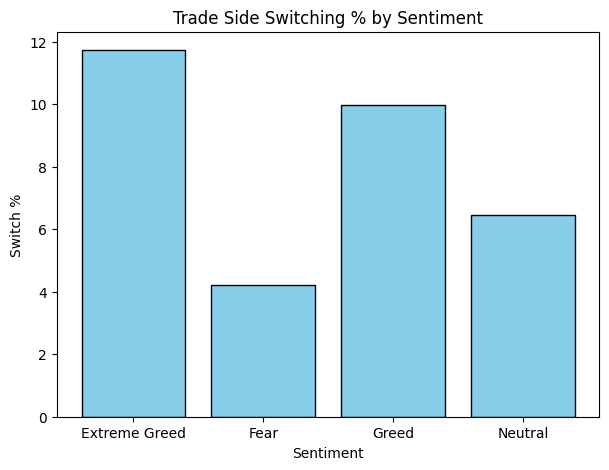

In [22]:
# Ensure your timestamp is in datetime format
merged_df['trade_time_utc'] = pd.to_datetime(merged_df['trade_time_utc'])

# Sort by trader and trade time
merged_df = merged_df.sort_values(by=['Account', 'trade_time_utc'])

# Check if the trade side changed compared to the previous trade (per account & sentiment)
merged_df['Side_Changed'] = merged_df.groupby(['Account', 'classification'])['Side'].transform(lambda x: x != x.shift())

# Count number of switches (True values where change happened)
switch_counts = merged_df[merged_df['Side_Changed']].groupby('classification').size().reset_index(name='Switch Count')

# Count total trades per sentiment for normalization
total_trades = merged_df.groupby('classification').size().reset_index(name='Total Trades')

# Merge to get switch percentage
switch_stats = switch_counts.merge(total_trades, on='classification')
switch_stats['Switch %'] = (switch_stats['Switch Count'] / switch_stats['Total Trades']) * 100

print("=== Switching Behavior by Sentiment ===")
print(switch_stats)

# Optional: Plot switching percentage
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.bar(switch_stats['classification'], switch_stats['Switch %'], color='skyblue', edgecolor='black')
plt.title('Trade Side Switching % by Sentiment')
plt.ylabel('Switch %')
plt.xlabel('Sentiment')
os.makedirs('outputs', exist_ok=True)
plt.savefig("outputs/traders_switching.png", dpi=300, bbox_inches='tight')
plt.show()

## HeatMap

/tmp/ipython-input-3716497125.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = merged_df.groupby(['classification', 'Trade Size Bin'])['Closed PnL'].mean().unstack()


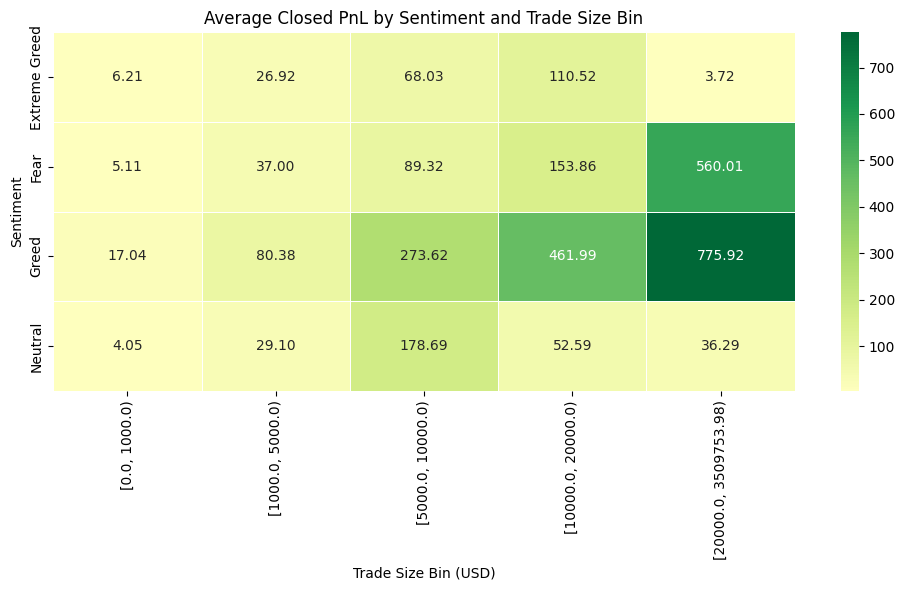

In [24]:
merged_df['Size USD'] = pd.to_numeric(merged_df['Size USD'], errors='coerce')
merged_df['Closed PnL'] = pd.to_numeric(merged_df['Closed PnL'], errors='coerce')

size_bins = [0, 1000, 5000, 10000, 20000, merged_df['Size USD'].max() + 1]
merged_df['Trade Size Bin'] = pd.cut(
    merged_df['Size USD'],
    bins=size_bins,
    right=False,
    include_lowest=True
)

heatmap_data = merged_df.groupby(['classification', 'Trade Size Bin'])['Closed PnL'].mean().unstack()


plt.figure(figsize=(10,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap='RdYlGn',
    center=0,
    linewidths=0.5
)
plt.title('Average Closed PnL by Sentiment and Trade Size Bin')
plt.xlabel('Trade Size Bin (USD)')
plt.ylabel('Sentiment')
plt.tight_layout()
plt.show()


In [27]:
heatmap_data = merged_df.groupby(['classification', 'Trade Size Bin'])['Closed PnL'].mean().unstack()
os.makedirs('csv', exist_ok=True)
heatmap_data.to_csv('csv/pnl_heatmap_data.csv')


/tmp/ipython-input-1402515605.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = merged_df.groupby(['classification', 'Trade Size Bin'])['Closed PnL'].mean().unstack()
